In [91]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import entropy
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')


In [2]:
df = pd.read_csv('../../projects/data/bolcom-clicks-35m_test.txt', sep='\t')
df


,SessionId,Time,ItemId
0,0008019740_18,1585897352,9200000083733268
1,0008019740_18,1585897382,9200000049819763
2,0008019740_18,1585897392,9200000066323079
3,0008019740_18,1585897506,9200000081546242
4,0008019740_18,1585897633,9200000125623273
...,...,...,...
1211470,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921127,9200000065118578
1211471,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921160,9200000065118570
1211472,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921286,9200000064417495
1211473,zzzjsuzmx87wcp4720be75zq67m2hkx9_14,1585944407,9200000026328200


In [4]:
def create_index_df_from_column(argument_df, columnname):
    # create an index for the training item_ids, because we need this when training the model
    # this should be part of the train and serve code of an algorithm
    # usage:
    #     create_index_df_from_column(df, 'ItemId')
    # returns a two column dataframe:
    #   ItemId  idx
    #   9200000105095118    0
    #   9200000041902190    1
    #   9200000095595490    2
    token_id = {t: i for i, t in enumerate(argument_df[columnname].unique())}
    df_index = pd.DataFrame.from_dict(token_id, orient="index").reset_index()
    df_index.rename(columns={"index": columnname, 0: "idx"}, inplace=True)
    return df_index

In [5]:
item_pop_df = df.groupby('ItemId').size()
item_pops_df = item_pop_df.to_frame('qty').reset_index()
item_pops_df.sort_values(by=['qty'], inplace=True)
item_idx = create_index_df_from_column(item_pops_df, 'ItemId')
dfs = item_pops_df.merge(item_idx, on='ItemId')
dfs

,ItemId,qty,idx
0,9200000092996478,1,0
1,9200000066211433,1,1
2,9200000123889779,1,2
3,9200000066211493,1,3
4,9200000066211497,1,4
...,...,...,...
338412,9200000110533529,2073,338412
338413,9200000056292168,2177,338413
338414,9200000026848187,2186,338414
338415,9200000047735877,2224,338415


In [131]:
f_obs = dfs['qty']
requested_distribution = 'genhyperbolic'
supported_distros = set(_distn_names) - set(['levy_stable', 'studentized_range'])
if requested_distribution in supported_distros:
    distribution = requested_distribution
else:
    print('Invalid configuration error: Distribution \''+requested_distribution +'\' is unknown. Supported distributions: '+ str(supported_distros))
distribution

'genhyperbolic'

In [132]:
results = []
for distribution_name in supported_distros:
    
    distribution = getattr(st, distribution_name)
    # Try to fit the distribution
    # try:
    #     # Ignore warnings from data that can't be fit
    #     with warnings.catch_warnings():
    #         warnings.filterwarnings('ignore')

    # fit dist to data
    fit_params = distribution.fit(f_obs)
    # number of new items
    m = len(f_obs)
    f_new = distribution.rvs(*fit_params, size=m)
    f_new = (np.rint(f_new)).astype(int)
    f_new = np.sort(f_new)

    p_obs = f_obs / np.sum(f_obs)
    p_new = f_new / np.sum(f_new)

    kl_divergence_obs_synth = entropy(p_obs, p_new)

    # identify if this distribution is better
    results.append((distribution, fit_params, kl_divergence_obs_synth))

    print('distribution_name:' + str(distribution_name) + ' KL divergence' + str(kl_divergence_obs_synth))


KeyboardInterrupt: 

In [136]:
distribution_name = 'powerlaw'
distribution = getattr(st, distribution_name)
# Try to fit the distribution
# try:
#     # Ignore warnings from data that can't be fit
#     with warnings.catch_warnings():
#         warnings.filterwarnings('ignore')

# fit dist to data
fit_params = distribution.fit(f_obs)
# number of new items
m = len(f_obs)
f_new = distribution.rvs(*fit_params, size=m)
f_new = (np.rint(f_new)).astype(int)
f_new = np.sort(f_new)

p_obs = f_obs / np.sum(f_obs)
p_new = f_new / np.sum(f_new)

kl_divergence_obs_synth = entropy(p_obs, p_new)

# identify if this distribution is better
results.append((distribution, fit_params, kl_divergence_obs_synth))

print('distribution_name:' + str(distribution_name) + ' KL divergence' + str(kl_divergence_obs_synth))


distribution_name:powerlaw KL divergence1.1900087826148418


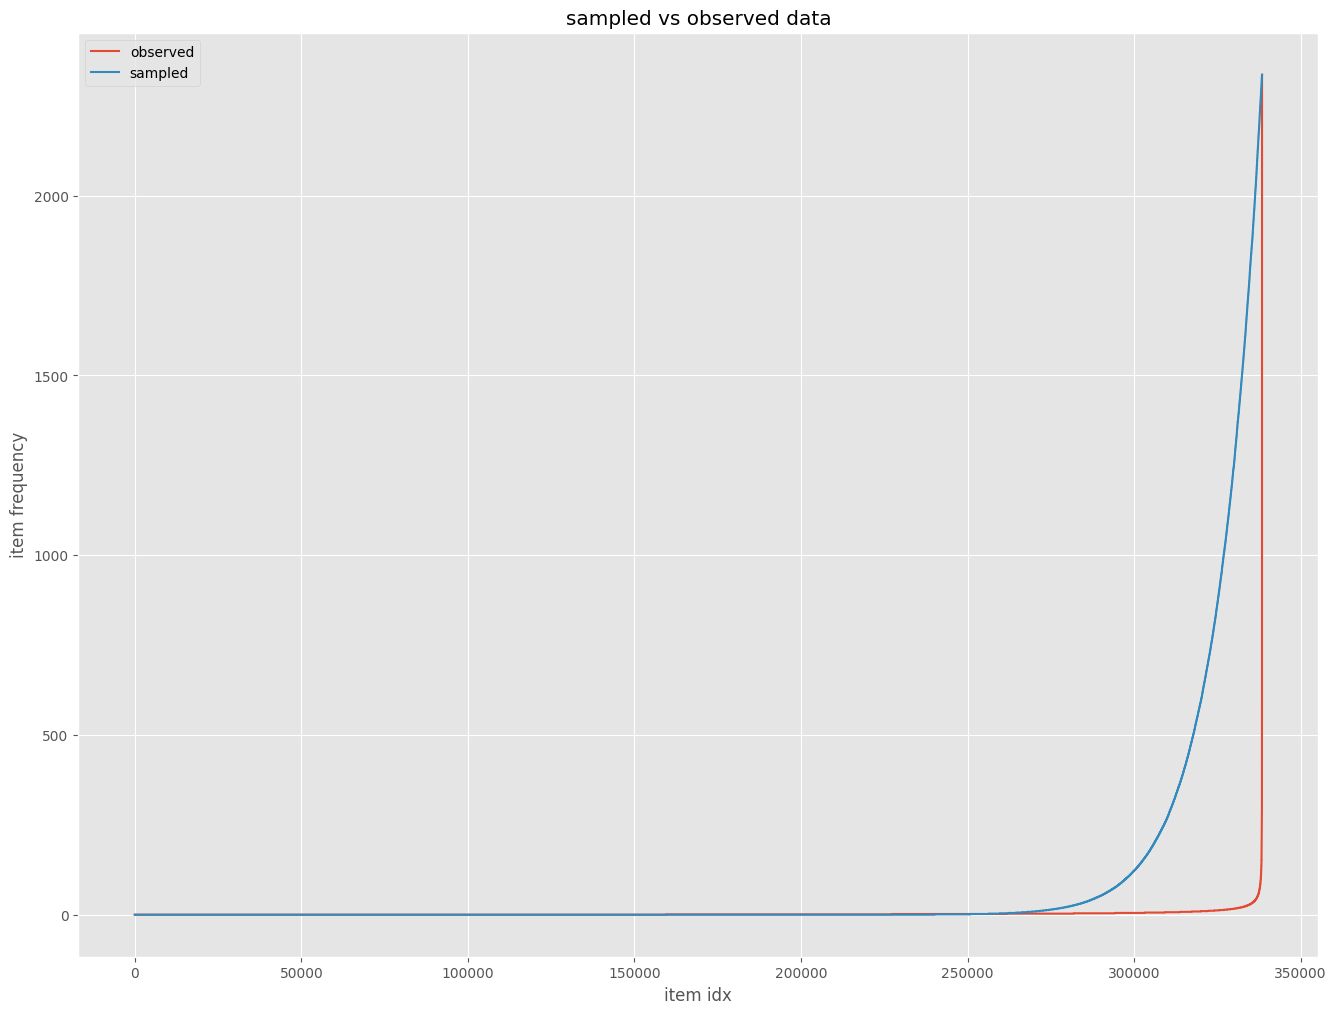

In [137]:
plt.title('sampled vs observed data')
plt.plot(f_obs, label='observed')
plt.plot(f_new, label='sampled')
plt.legend(loc='upper left')
plt.xlabel('item idx')
plt.ylabel('item frequency')
plt.show()

In [130]:
sorted(results, key=lambda x:x[2])

[(<scipy.stats._continuous_distns.genhyperbolic_gen at 0x1377b0610>,
  (0.021691646642594563,
   4.170631263151301,
   4.1706309552694645,
   0.9999797595058064,
   9.06961424055769e-06),
  0.0899855123946117),
 (<scipy.stats._continuous_distns.chi2_gen at 0x1371897f0>,
  (1.5214943207785407, 0.9999999999999998, 13.056816972153538),
  0.19240466610791518),
 (<scipy.stats._continuous_distns.nakagami_gen at 0x1378b8b20>,
  (0.13371793299113896, 0.9999999999999998, 19.784343773648867),
  0.20592954397813157),
 (<scipy.stats._continuous_distns.chi_gen at 0x13719d580>,
  (0.37366035450921686, 0.9999999999999999, 16.95859857013626),
  0.20891251239590175),
 (<scipy.stats._continuous_distns.ncx2_gen at 0x1378bd2e0>,
  (0.1912850862762374,
   0.7395604016242814,
   0.9999999999999999,
   10.422829312722735),
  0.21237971660839206),
 (<scipy.stats._continuous_distns.beta_gen at 0x137181040>,
  (0.4291207050121978,
   4524.436941645967,
   0.9999999502883389,
   9447.861323438894),
  0.231416658